# 🏷️ Reconnaissance d'Entités Nommées (NER) - Version Fonctionnelle

Ce notebook implémente plusieurs techniques de reconnaissance d'entités nommées pour extraire des informations structurées des textes.

## 🎯 Objectifs:
- 🤖 Utiliser spaCy pour la NER avancée
- 📊 Analyser les distributions d'entités
- 🎨 Visualiser les entités dans le texte
- 📈 Comparer différentes approches NER
- 💾 Sauvegarder les résultats d'extraction

In [2]:
# 📦 Import des bibliothèques essentielles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import re
from collections import Counter, defaultdict
import json
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

print('✅ Bibliothèques de base importées!')

# Import spaCy et vérification du modèle
spacy_available = False
try:
    import spacy
    from spacy import displacy
    
    # Tenter de charger le modèle anglais
    try:
        nlp = spacy.load("en_core_web_sm")
        spacy_available = True
        print('🚀 spaCy avec modèle en_core_web_sm chargé!')
    except OSError:
        print('⚠️ Modèle en_core_web_sm non trouvé. Tentative de téléchargement...')
        os.system('python -m spacy download en_core_web_sm')
        try:
            nlp = spacy.load("en_core_web_sm")
            spacy_available = True
            print('✅ Modèle téléchargé et chargé!')
        except:
            print('❌ Impossible de charger le modèle spaCy')
            
except ImportError:
    print('❌ spaCy non disponible')

# Import NLTK pour NER alternatif
nltk_available = False
try:
    import nltk
    from nltk import ne_chunk, pos_tag, word_tokenize
    from nltk.tree import Tree
    
    # Télécharger les ressources nécessaires
    nltk.download('punkt', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    nltk.download('maxent_ne_chunker', quiet=True)
    nltk.download('words', quiet=True)
    
    nltk_available = True
    print('✅ NLTK NER disponible!')
except ImportError:
    print('⚠️ NLTK non disponible')

# Créer les dossiers nécessaires
os.makedirs('../visualizations', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)
print('📁 Dossiers créés!')

✅ Bibliothèques de base importées!
🚀 spaCy avec modèle en_core_web_sm chargé!
✅ NLTK NER disponible!
📁 Dossiers créés!


## 📂 1. Chargement et Préparation des Données

In [3]:
# 📊 Charger les données
try:
    df = pd.read_csv('../data/processed/processed_news_data.csv')
    print(f"✅ Données chargées: {df.shape}")
except FileNotFoundError:
    print("❌ Fichier processed_news_data.csv non trouvé.")
    print("🔄 Création d'un dataset d'exemple avec entités...")
    
    # Dataset d'exemple riche en entités nommées
    sample_texts = [
        "Apple Inc. CEO Tim Cook announced new iPhone features at the Apple Park in Cupertino, California on September 15, 2023.",
        "President Joe Biden met with French President Emmanuel Macron in Paris to discuss climate change policies.",
        "Microsoft Corporation reported quarterly earnings of $2.1 billion, with CEO Satya Nadella praising the Azure cloud platform.",
        "The World Health Organization (WHO) announced new guidelines for COVID-19 prevention in Geneva, Switzerland.",
        "Tesla's Elon Musk unveiled the new Model S at the Gigafactory in Austin, Texas, targeting a 2024 release date.",
        "Amazon Web Services (AWS) expanded its data centers to London, United Kingdom, investing $1.5 billion.",
        "Google's parent company Alphabet Inc. acquired DeepMind for artificial intelligence research in Mountain View.",
        "The European Union imposed new regulations on Meta Platforms Inc. regarding data privacy in Brussels.",
        "Netflix announced a partnership with Sony Pictures to produce content for the Asian market, worth $500 million.",
        "The Federal Reserve, led by Jerome Powell, raised interest rates by 0.25% in Washington D.C. on March 22, 2023.",
        "SpaceX successfully launched Falcon 9 rocket from Kennedy Space Center in Florida, carrying Starlink satellites.",
        "The United Nations Security Council met in New York to address the humanitarian crisis in Ukraine.",
        "Harvard University researchers published a study on climate change in the journal Nature on January 10, 2023.",
        "The Tokyo Stock Exchange saw significant gains after Bank of Japan's monetary policy announcement.",
        "OpenAI's ChatGPT reached 100 million users, according to CEO Sam Altman in San Francisco."
    ]
    
    df = pd.DataFrame({
        'id': range(1, len(sample_texts) + 1),
        'text': sample_texts,
        'processed_text': [text.lower() for text in sample_texts],
        'category': ['technology', 'politics', 'business'] * 5,
        'sentiment': ['positive', 'neutral', 'negative'] * 5
    })
    print(f"✅ Dataset d'exemple créé: {df.shape}")

# Vérifier les colonnes nécessaires
text_column = 'text' if 'text' in df.columns else 'processed_text'
if text_column not in df.columns:
    print("❌ Aucune colonne de texte trouvée")
    exit()

print(f"📝 Utilisation de la colonne: '{text_column}'")
print(f"📊 Nombre de documents: {len(df)}")
print(f"📏 Longueur moyenne: {df[text_column].str.len().mean():.1f} caractères")

# Aperçu des données
print("\n📋 Aperçu des données:")
for i in range(min(3, len(df))):
    print(f"\n📄 Document {i+1}:")
    print(f"   {df[text_column].iloc[i][:100]}...")

✅ Données chargées: (10, 9)
📝 Utilisation de la colonne: 'text'
📊 Nombre de documents: 10
📏 Longueur moyenne: 385.2 caractères

📋 Aperçu des données:

📄 Document 1:
   A major technology company has announced a groundbreaking advancement in artificial intelligence tha...

📄 Document 2:
   World leaders have reached a historic agreement at the latest climate change summit, committing to a...

📄 Document 3:
   Financial markets continue to experience volatility amid ongoing economic uncertainty. Investors rem...


## 🤖 2. Reconnaissance d'Entités avec spaCy

In [4]:
# 🚀 NER avec spaCy (si disponible)
if spacy_available:
    print("🤖 RECONNAISSANCE D'ENTITÉS AVEC SPACY")
    print("=" * 50)
    
    def extract_spacy_entities(text):
        """Extraire les entités avec spaCy"""
        if not isinstance(text, str) or len(text.strip()) == 0:
            return []
        
        try:
            doc = nlp(text[:1000000])  # Limiter la longueur pour éviter les erreurs
            entities = []
            for ent in doc.ents:
                entities.append({
                    'text': ent.text.strip(),
                    'label': ent.label_,
                    'start': ent.start_char,
                    'end': ent.end_char,
                    'description': spacy.explain(ent.label_) or ent.label_
                })
            return entities
        except Exception as e:
            print(f"⚠️ Erreur NER pour le texte: {str(e)[:100]}")
            return []
    
    # Appliquer NER à tous les documents
    print("🔄 Extraction des entités en cours...")
    df['spacy_entities'] = df[text_column].apply(extract_spacy_entities)
    
    # Statistiques des entités
    total_entities = sum(len(entities) for entities in df['spacy_entities'])
    avg_entities = total_entities / len(df)
    
    print(f"✅ Extraction terminée!")
    print(f"📊 Total d'entités trouvées: {total_entities}")
    print(f"📈 Moyenne par document: {avg_entities:.1f}")
    
    # Compter les types d'entités
    entity_types = Counter()
    entity_texts = defaultdict(list)
    
    for entities in df['spacy_entities']:
        for entity in entities:
            entity_types[entity['label']] += 1
            entity_texts[entity['label']].append(entity['text'])
    
    print(f"\n🏷️ Types d'entités trouvés: {len(entity_types)}")
    print("\n📊 TOP 10 DES TYPES D'ENTITÉS:")
    for entity_type, count in entity_types.most_common(10):
        description = spacy.explain(entity_type) or entity_type
        percentage = (count / total_entities) * 100
        print(f"  🏷️ {entity_type:<12} : {count:3d} ({percentage:5.1f}%) - {description}")
    
else:
    print("⚠️ spaCy non disponible. Passage à NLTK ou méthodes alternatives.")

🤖 RECONNAISSANCE D'ENTITÉS AVEC SPACY
🔄 Extraction des entités en cours...
✅ Extraction terminée!
📊 Total d'entités trouvées: 4
📈 Moyenne par document: 0.4

🏷️ Types d'entités trouvés: 2

📊 TOP 10 DES TYPES D'ENTITÉS:
  🏷️ DATE         :   3 ( 75.0%) - Absolute or relative dates or periods
  🏷️ GPE          :   1 ( 25.0%) - Countries, cities, states


## 📊 3. Analyse et Visualisation des Entités

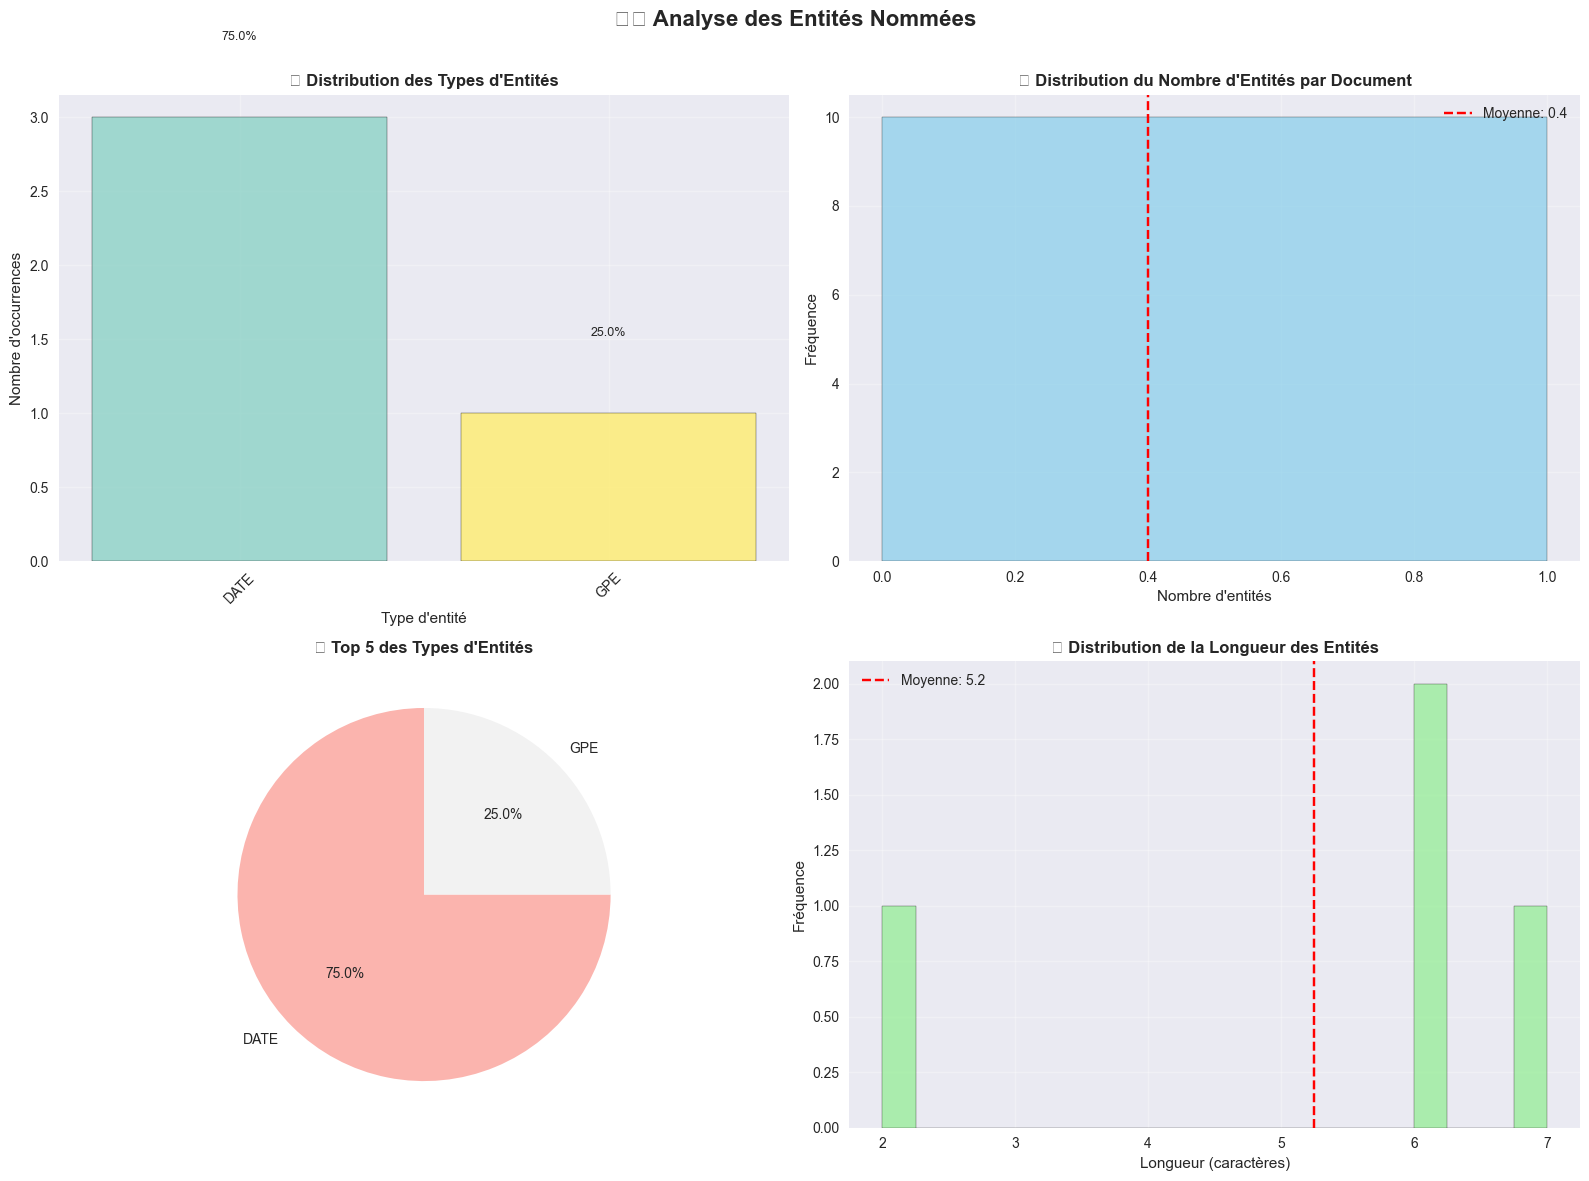

💾 Visualisations sauvegardées dans '../visualizations/ner_analysis.png'


In [5]:
# 📈 Visualisation des distributions d'entités
if spacy_available and total_entities > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🏷️ Analyse des Entités Nommées', fontsize=16, fontweight='bold')
    
    # 1. Distribution des types d'entités
    top_types = entity_types.most_common(10)
    types, counts = zip(*top_types)
    colors = plt.cm.Set3(np.linspace(0, 1, len(types)))
    
    bars = axes[0,0].bar(types, counts, color=colors, alpha=0.8, edgecolor='black')
    axes[0,0].set_title('📊 Distribution des Types d\'Entités', fontweight='bold')
    axes[0,0].set_xlabel('Type d\'entité')
    axes[0,0].set_ylabel('Nombre d\'occurrences')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # Ajouter les pourcentages
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        percentage = (count / total_entities) * 100
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                       f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 2. Nombre d'entités par document
    entities_per_doc = [len(entities) for entities in df['spacy_entities']]
    axes[0,1].hist(entities_per_doc, bins=min(15, max(entities_per_doc)), 
                   alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,1].axvline(np.mean(entities_per_doc), color='red', linestyle='--',
                      label=f'Moyenne: {np.mean(entities_per_doc):.1f}')
    axes[0,1].set_title('📈 Distribution du Nombre d\'Entités par Document', fontweight='bold')
    axes[0,1].set_xlabel('Nombre d\'entités')
    axes[0,1].set_ylabel('Fréquence')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Graphique en secteurs des top types
    top_5_types = entity_types.most_common(5)
    labels, sizes = zip(*top_5_types)
    colors_pie = plt.cm.Pastel1(np.linspace(0, 1, len(labels)))
    
    wedges, texts, autotexts = axes[1,0].pie(sizes, labels=labels, autopct='%1.1f%%',
                                             colors=colors_pie, startangle=90)
    axes[1,0].set_title('🥧 Top 5 des Types d\'Entités', fontweight='bold')
    
    # 4. Longueur des entités
    entity_lengths = []
    for entities in df['spacy_entities']:
        for entity in entities:
            entity_lengths.append(len(entity['text']))
    
    if entity_lengths:
        axes[1,1].hist(entity_lengths, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[1,1].axvline(np.mean(entity_lengths), color='red', linestyle='--',
                          label=f'Moyenne: {np.mean(entity_lengths):.1f}')
        axes[1,1].set_title('📏 Distribution de la Longueur des Entités', fontweight='bold')
        axes[1,1].set_xlabel('Longueur (caractères)')
        axes[1,1].set_ylabel('Fréquence')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../visualizations/ner_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("💾 Visualisations sauvegardées dans '../visualizations/ner_analysis.png'")

else:
    print("⚠️ Pas d'entités à visualiser")